In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 把它转换成 tensor，映射到0到1之间的浮点数 因为一开始读进来可能是numpy的
# transforms.Normalize(mean, std) 表示将图像的每个通道（R、G、B）的像素值分别减去0.5并除以0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 每次测试或小批量训练的样本数为 4
batch_size = 4

# 训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# shuffle=True表示在每个epoch训练之前对数据进行洗牌 num_workers=2表示使用2个子进程来加载数据
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# 测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## DenseNet 网络搭建
1. 特征图大小保持一致
2. DenseBlock 是包含很多层的模块，每个层的特征图大小相同，层与层之间密集连接。
3. Transition 模块是连接两个相邻的 DenseBlock，通过池化使特征图大小降低。

### DenseBlock
- BN + RELU + 3*3 Conv
l层的输入channel数为 $k_{0}$ + (l - 1)k ,k 是 growth rate。k 设比较小如12。
顺序 BN + RELU + 3*3 Conv（叫pre-activation）效果更好
#### bottleneck层
用来减少计算量，就是进行两次BN激活卷积（一个是1*1一个是3*3）。
- BN + RELU + 1*1 Conv + BN + RELU + 3*3 Conv （叫做DenseBlock—B结构）
1*1 Conv 用来降低特征数量，计算更快。
每个 bottleneck层输出通道数是相同的。

### Transition
连接denseblock，降低特征图大小。包括 1*1 的卷积和 2*2 的平均池化。
压缩模型。原来有m个特征，压缩后有 cm 个，c是压缩系数。c一般是0.5 这种结构叫 DenseNet-C

### 优势
卷积+池化+denseblock+transition+denseblock……
同等参数大小，DenseNet 优于 ResNet。
1. 由于密集连接，提升了梯度的反向传播，网络更容易训练。误差信号可以很容易传播到较早的层。减轻梯度消失现象，更深网络不是问题。
2. 参数量减少。
3. 保存了低维度特征。传统的卷积只提取了高层次的特征。即使训练数据少效果也会不错。
#### 不足
1. 多次Concatnate，数据需要复制多次，显存增加得快。


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class DenseLayer(nn.Module):
    """
    DenseBlock 的一层 输出通道数是 in_channel + growth
    """
    def __init__(self, in_channel, growth):
        super(DenseLayer, self).__init__()
        # 1*1
        self.bn1 = nn.BatchNorm2d(in_channel)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channel, growth * 4, kernel_size=1, stride=1, padding=0, bias=False)
        # 2*2
        self.bn2 = nn.BatchNorm2d(growth * 4)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(growth * 4, growth, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        # print(f"    @DenseLayer the shape of x is {x.shape}")
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        # print(f"    @DenseLayer after conv1 is {out.shape}")
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        # print(f"    @DenseLayer after conv1 is {out.shape}")
        final_out = torch.cat((x, out), 1)
        # print(f"    @DenseLayer final_out is {final_out.shape}")
        return final_out


class DenseBlock(nn.Module):
    """
    Dense Block
    """
    def __init__(self, in_channel, growth, layer_num=2):
        super(DenseBlock, self).__init__()
        # 一个 denseblock ：2 denselayer
        self.layer1 = DenseLayer(in_channel, growth)
        self.layer2 = DenseLayer(in_channel + growth, growth)

        # for i in range(layer_num):
        #     layer_name = "layer"

    def forward(self, x):
        # print(f"  @DenseBlock start shape {x.shape}")
        out = self.layer1(x)
        # print(f"  @DenseBlock after layer1 {out.shape}")
        out = self.layer2(out)
        # print(f"  @DenseBlock after layer2 {out.shape}")
        return out


class Transition(nn.Module):
    def __init__(self, in_channel):
        super(Transition, self).__init__()
        self.bn_mid = nn.BatchNorm2d(in_channel)
        self.relu_mid = nn.ReLU()
        self.conv_mid = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, bias=False)
        self.avgpool_mid = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.bn_mid(x)
        out = self.relu_mid(out)
        out = self.conv_mid(out)
        out = self.avgpool_mid(out)
        return out

class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        # prepare
        self.conv0 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn0 = nn.BatchNorm2d(32)
        self.relu0 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        # into denseblock
        self.db1 = DenseBlock(32, 32)
        self.transt = Transition(96)
        self.db2 = DenseBlock(64, 32)

        # 全连接
        self.fc1 = nn.Linear(1152, 400)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(400, 10)

    def forward(self, x):
        # print(f"@DenseNet the shape of x is {x.shape}")
        out = self.conv0(x)
        # print(f"@DenseNet after conv0 {out.shape}")
        out = self.bn0(out)
        # print(f"@DenseNet after bn0 {out.shape}")
        out = self.relu0(out)
        # print(f"@DenseNet after relu0 {out.shape}")
        out = self.maxpool(out)
        # print(f"@DenseNet after maxpool {out.shape}")
        out = self.db1(out)
        out = self.transt(out)
        out = self.db2(out)
        # print(f"@DenseNet after denseblock2 the shape is {out.shape}")
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu_fc1(out)
        out = self.fc2(out)
        # print(f"@DenseNet final out is {out.shape}")
        return out

    #
    # def forward(self):
    #     pass


In [5]:
def test():
    densenet = DenseNet()
    # 输入数据
    input_data = torch.randn(1, 3, 32, 32)

    # 前向传播
    output = densenet(input_data)
    print(densenet)

In [6]:
# 测试
test()

DenseNet(
  (conv0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (db1): DenseBlock(
    (layer1): DenseLayer(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (layer2): DenseLayer(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, ep

In [7]:
densenet = DenseNet()
print(densenet)

DenseNet(
  (conv0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (db1): DenseBlock(
    (layer1): DenseLayer(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (layer2): DenseLayer(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, ep

In [8]:
import torch.optim as optim
# 定义损失函数，交叉熵损失
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)

In [9]:
# 单个 epoch 的训练过程
def train(epoch):
    # Set model to training mode
    # 训练模式
    densenet.train()
    
    running_loss = 0.0
    correct = 0 # 正确预测的图片
    total = 0 # 总数
    cur_loss = 0
    
    # Loop over each batch from the training set
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = densenet(inputs)
        loss = criterion(outputs, labels)
        # 对损失函数进行反向传播
        loss.backward()
        # Update weights
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        cur_loss += loss.item()
#         # 计算每轮预测正确的图片及图片总数
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
                
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'Train Epoch:{epoch }  [{i - 1999:5d}, {i + 1:5d}] loss: {running_loss / 2000:.3f} accuracy:{correct / total * 100}')      
            running_loss = 0.0

In [10]:
# 用于在验证集上评估训练好的模型的性能
def validate(loss_vector, accuracy_vector):
    # 将模型设置为评估模式
    densenet.eval()
    val_loss, correct = 0, 0
    # 循环
    for data, target in testloader:
#         data = data.to(device)
#         target = target.to(device)
        output = densenet(data)
    
        # 损失累加到 val_loss 变量中
        val_loss += criterion(output, target).data.item()
        # 预测
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
    # 在循环结束后，计算整个验证集上的平均损失，并将其附加到 loss_vector 列表中。
    # 计算模型在整个验证集上的精度，并将其附加到 accuracy_vector 列表中。
    # 函数最后会打印出平均损失和精度。
    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))

In [11]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch:1  [    0,  2000] loss: 1.767 accuracy:35.675000000000004
Train Epoch:1  [ 2000,  4000] loss: 1.482 accuracy:40.7125
Train Epoch:1  [ 4000,  6000] loss: 1.346 accuracy:44.420833333333334
Train Epoch:1  [ 6000,  8000] loss: 1.258 accuracy:47.115625
Train Epoch:1  [ 8000, 10000] loss: 1.196 accuracy:49.3075
Train Epoch:1  [10000, 12000] loss: 1.140 accuracy:51.04791666666667

Validation set: Average loss: 1.0402, Accuracy: 6360/10000 (64%)

Train Epoch:2  [    0,  2000] loss: 1.033 accuracy:63.81250000000001
Train Epoch:2  [ 2000,  4000] loss: 1.009 accuracy:64.2875
Train Epoch:2  [ 4000,  6000] loss: 0.986 accuracy:64.68333333333334
Train Epoch:2  [ 6000,  8000] loss: 0.967 accuracy:64.95
Train Epoch:2  [ 8000, 10000] loss: 0.936 accuracy:65.4125
Train Epoch:2  [10000, 12000] loss: 0.912 accuracy:65.82708333333333

Validation set: Average loss: 0.9167, Accuracy: 6812/10000 (68%)

Train Epoch:3  [    0,  2000] loss: 0.808 accuracy:72.2
Train Epoch:3  [ 2000,  4000] loss: 0.81

<Figure size 500x300 with 0 Axes>

Text(0.5, 1.0, 'validation loss')

<Figure size 500x300 with 0 Axes>

Text(0.5, 1.0, 'validation accuracy')

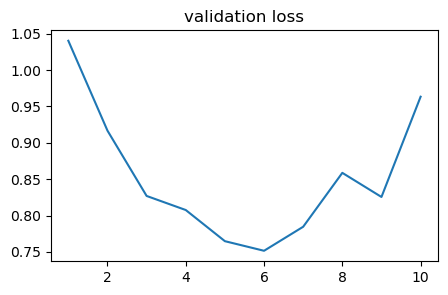

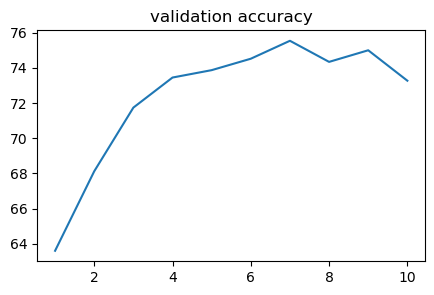

In [12]:
# 损失
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')
# 准确率
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')